# Eliminación de anomalías de una imagen

## Introducción

## Librerías a utilizar
### Librerías para el procesamiento de imágenes

In [39]:
import cv2 as cv
import numpy as np

### Librería opcional para mostrar imagenes en el notebook

Esta librería espera imágenes RGB de otra manera los tonos y colores serán distintos. Para ver las imágenes de salida con detalle es necesario ir a la carpeta `out`. Las imágenes de entrada se encuentran en la carpeta `im`.

In [40]:
from matplotlib import pyplot as plt

## Carga de imágenes

In [41]:
image_unir = cv.imread('im/unir-1.jpg')
image_rgb = cv.imread('im/rgb.png')
image_snp = cv.imread('im/salt-pepper.png')
image_noisy = cv.imread('im/noisy.jpg')

## Operación de convolución por promedio

### Uso de OpenCV

In [42]:
def mask(n):
    '''Define a nxn mask.
    Useful for a quick filter
    '''
    mask = np.ones((n,n), np.float32)*(1/(n**2))
    return mask

kernel = mask(5)
print(kernel)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Ahora se debe probar con la función `cv.filter2D()`. No es necesario hacer nuevas funciones.

In [43]:
im = image_unir
out = cv.filter2D(im,-1,kernel)
cv.imwrite('out/filter2D.jpg', out)

True

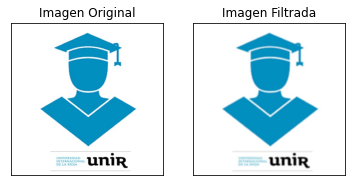

In [44]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Imagen Original')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2) 
plt.imshow(out)
plt.title('Imagen Filtrada')
plt.xticks([])
plt.yticks([])
plt.show()

Puede observarse como resultado del filtro que la imagen se difumina ligeramente, sobre todo en el texto. Ahora si el valor de la máscara es muy alto, por ejemplo 50, se notará un fuerte efecto de difuminado en la imagen.

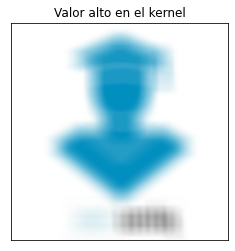

In [45]:
kernel = mask(50)
out = cv.filter2D(im,-1,kernel)
cv.imwrite('out/filter2D-bigKernel.jpg', out)
plt.imshow(out)
plt.title('Valor alto en el kernel'), plt.xticks([]), plt.yticks([])
plt.show()

El efecto de limpieza de ruido con este filtro pasa baja (LPF) puede observarse al usarlo con las imágenes `image_noisy` e `image_snp`. La primera es una foto del año 2008 tomada con una cámara marca Nikon, si se ve con detenimiento se verá la cantidad de ruido de la misma. La segunda es una clásica imagen con ruido _sal y pimienta_. 

In [46]:
# Mantener comentada una de las próximas dos líneas para observar el resultado del filtro
im = image_noisy
#im = image_snp
# Cambie el tamaño de la máscara si así lo desea
kernel = mask(7)
out = cv.filter2D(im,-1,kernel)
cv.imwrite('out/filter2D-cleaning.jpg', out)

True

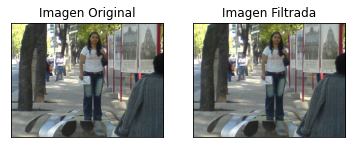

In [47]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Imagen Original')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2) 
plt.imshow(out)
plt.title('Imagen Filtrada')
plt.xticks([])
plt.yticks([])
plt.show()

Es notorio que este filtro tiene un efecto relativo sobre el ruido: en el caso _sal y pimienta_ limpia muy poco la imagen, mientras tanto, en sobre el ruido aleatorio es casi imperceptible alguna mejora. Por eso se deben usar otro tipo de filtros.

## Filtro gausiano

In [48]:
im = image_noisy
out = cv.cvtColor(im, cv.COLOR_BGR2GRAY) 
out = cv.GaussianBlur(im,(21,21),0)
cv.imwrite('out/gaussian-1.jpg', out)

True

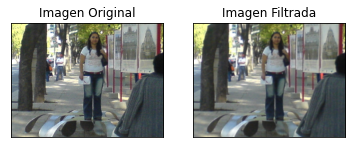

In [51]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Imagen Original')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2) 
plt.imshow(out)
plt.title('Imagen Filtrada')
plt.xticks([])
plt.yticks([])
plt.show()